#  VesselMNIST3D Classification



In [1]:
pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.6 MB/s eta 0:00:00


In [2]:
# Imports
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from medmnist import VesselMNIST3D
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"GPU error: {e}")

print("TensorFlow version:", tf.__version__)

Found 1 GPU(s)
TensorFlow version: 2.19.0


In [3]:
# Load data
train_dataset = VesselMNIST3D(split='train', size=28, download=True)
val_dataset = VesselMNIST3D(split='val', size=28, download=True)
test_dataset = VesselMNIST3D(split='test', size=28, download=True)

trainx = np.array([train_dataset[i][0] for i in range(len(train_dataset))])
trainy = np.array([train_dataset[i][1][0] for i in range(len(train_dataset))])

valx = np.array([val_dataset[i][0] for i in range(len(val_dataset))])
valy = np.array([val_dataset[i][1][0] for i in range(len(val_dataset))])

testx = np.array([test_dataset[i][0] for i in range(len(test_dataset))])
testy = np.array([test_dataset[i][1][0] for i in range(len(test_dataset))])

print(f"Train X shape: {trainx.shape}, Train y shape: {trainy.shape}")
print(f"Val X shape: {valx.shape}, Val y shape: {valy.shape}")
print(f"Test X shape: {testx.shape}, Test y shape: {testy.shape}")

# Class distribution
n_class0 = np.sum(trainy == 0)
n_class1 = np.sum(trainy == 1)
print(f"\nClass distribution - Class 0: {n_class0}, Class 1: {n_class1}")
print(f"Imbalance ratio: {n_class0 / n_class1:.1f}:1")

100%|██████████| 398k/398k [00:00<00:00, 435kB/s]


Train X shape: (1335, 1, 28, 28, 28), Train y shape: (1335,)
Val X shape: (191, 1, 28, 28, 28), Val y shape: (191,)
Test X shape: (382, 1, 28, 28, 28), Test y shape: (382,)

Class distribution - Class 0: 1185, Class 1: 150
Imbalance ratio: 7.9:1


## Data Augmentation and Oversampling
Address class imbalance by augmenting minority class samples (aneurysm cases). The `augment_3d` function applies random 3D transformations including rotations, flips, shifts, and Gaussian noise. Target a 2:1 ratio (majority:minority) rather than 1:1 to prevent overfitting on augmented samples.

In [ ]:
# Lighter oversampling (2:1 ratio instead of 1:1)
# This prevents the model from memorizing augmented copies
from scipy.ndimage import rotate, shift

def augment_3d(volume):
    """3D augmentation for training"""
    aug = volume.copy()

    # Random rotation
    if np.random.rand() > 0.3:
        angle = np.random.uniform(-15, 15)
        axes_list = [(1,2), (1,3), (2,3)]
        axes = axes_list[np.random.randint(0, 3)]
        aug = rotate(aug, angle, axes=axes, reshape=False, mode='nearest', order=1)

    # Random flip
    for axis in [1, 2, 3]:
        if np.random.rand() > 0.5:
            aug = np.flip(aug, axis=axis).copy()

    # Small shift
    if np.random.rand() > 0.3:
        shift_vals = [0] + [np.random.randint(-2, 3) for _ in range(3)]
        aug = shift(aug, shift_vals, mode='nearest', order=0)

    # Random noise (lighter)
    if np.random.rand() > 0.5:
        noise = np.random.normal(0, 0.015, aug.shape)
        aug = np.clip(aug + noise, 0, 1)

    return aug

# Lighter oversampling: target 2:1 ratio (majority:minority)
class1_idx = np.where(trainy == 1)[0]
target_class1 = n_class0 // 2  # 2:1 ratio instead of 1:1
augmentations_needed = target_class1 - n_class1

print(f"Original: Class 0 = {n_class0}, Class 1 = {n_class1}")
print(f"Target: Class 1 = {target_class1} (2:1 ratio)")
print(f"Augmentations needed: {augmentations_needed}")

augmented_x, augmented_y = [], []
while len(augmented_x) < augmentations_needed:
    idx = np.random.choice(class1_idx)
    augmented_x.append(augment_3d(trainx[idx]))
    augmented_y.append(1)

trainx = np.concatenate([trainx, np.array(augmented_x)], axis=0)
trainy = np.concatenate([trainy, np.array(augmented_y)], axis=0)

# Shuffle
shuffle_idx = np.random.permutation(len(trainx))
trainx, trainy = trainx[shuffle_idx], trainy[shuffle_idx]

print(f"\nFinal: Class 0 = {np.sum(trainy==0)}, Class 1 = {np.sum(trainy==1)}")
print(f"Final ratio: {np.sum(trainy==0) / np.sum(trainy==1):.2f}:1")

Original: Class 0 = 1185, Class 1 = 150
Target: Class 1 = 592 (2:1 ratio)
Augmentations needed: 442

Final: Class 0 = 1185, Class 1 = 592
Final ratio: 2.00:1


## Data Preprocessing
Transpose the data from channels-first (NCDHW) to channels-last (NDHWC) format as required by TensorFlow. Convert all arrays to float32 for efficient computation. Verify the final data shape and value range.

In [5]:
# Transpose to channels_last format
trainx = trainx.transpose(0, 2, 3, 4, 1).astype(np.float32)
valx = valx.transpose(0, 2, 3, 4, 1).astype(np.float32)
testx = testx.transpose(0, 2, 3, 4, 1).astype(np.float32)

trainy = trainy.astype(np.float32)
valy = valy.astype(np.float32)
testy = testy.astype(np.float32)

print(f"Train shape: {trainx.shape}")
print(f"Data range: [{trainx.min():.3f}, {trainx.max():.3f}]")

Train shape: (1777, 28, 28, 28, 1)
Data range: [0.000, 1.000]


## Build the 3D CNN Model Architecture
Define an improved 3D ResNet-style architecture with Squeeze-and-Excitation (SE) attention blocks. The model features:
- Three residual blocks with increasing filter sizes (32 → 64 → 128)
- SE attention for channel-wise feature recalibration
- Spatial dropout for regularization
- Global average pooling followed by dense layers with L2 regularization
- Sigmoid output for binary classification

In [ ]:
# architecture with residual connections and SE blocks

def squeeze_excite_block(x, ratio=8):
    """Squeeze-and-Excitation block for channel attention"""
    channels = x.shape[-1]
    se = layers.GlobalAveragePooling3D()(x)
    se = layers.Dense(channels // ratio, activation='relu')(se)
    se = layers.Dense(channels, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, 1, channels))(se)
    return layers.Multiply()([x, se])

def residual_block(x, filters, kernel_size=3, stride=1, use_se=True, l2_reg=5e-3):
    """Residual block with optional SE attention"""
    shortcut = x

    # First conv
    x = layers.Conv3D(filters, kernel_size, strides=stride, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second conv
    x = layers.Conv3D(filters, kernel_size, padding='same',
                      kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)

    # SE block
    if use_se:
        x = squeeze_excite_block(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv3D(filters, 1, strides=stride, padding='same',
                                 kernel_regularizer=regularizers.l2(l2_reg))(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

def build_improved_resnet(input_shape=(28, 28, 28, 1), l2_reg=5e-3):
    """ 3D ResNet with SE blocks and stronger regularization"""
    inputs = layers.Input(shape=input_shape)

    # Initial conv
    x = layers.Conv3D(32, 3, padding='same', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Residual blocks with increasing filters
    x = residual_block(x, 32, l2_reg=l2_reg)
    x = layers.MaxPooling3D(2)(x)
    x = layers.SpatialDropout3D(0.2)(x)  # Spatial dropout works better for conv

    x = residual_block(x, 64, l2_reg=l2_reg)
    x = layers.MaxPooling3D(2)(x)
    x = layers.SpatialDropout3D(0.3)(x)

    x = residual_block(x, 128, l2_reg=l2_reg)
    x = layers.SpatialDropout3D(0.4)(x)

    # Global pooling and classifier
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dropout(0.5)(x)

    x = layers.Dense(64, kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

model = build_improved_resnet()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28,    │          0 │ -                 │
│ (InputLayer)        │ 28, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 28, 28,    │        896 │ input_layer[0][0] │
│                     │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ conv3d[0][0]      │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 28, 28,    │     27,680 │ activation[0][0]  │
│                     │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv3d_1[0][0]    │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 28, 28,    │     27,680 │ activation_1[0][… │
│                     │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv3d_2[0][0]    │
│ (BatchNormalizatio… │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        132 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 1,   │          0 │ dense_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 28, 32)           │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ multiply[0][0],   │
│                     │ 28, 32)           │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]         │
│ (Activation)        │ 28, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 14, 14,    │          0 │ activation_2[0][… │
│ (MaxPooling3D)      │ 14, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 913,405 (3.48 MB)

 Trainable params: 911,933 (3.48 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [ ]:
# Class weights to handle remaining imbalance
# Instead of forcing 1:1 ratio through oversampling

n_class0_final = np.sum(trainy == 0)
n_class1_final = np.sum(trainy == 1)

# Calculate class weights
total = n_class0_final + n_class1_final
class_weight = {
    0: total / (2 * n_class0_final),
    1: total / (2 * n_class1_final)
}
print(f"Class weights: {class_weight}")

Class weights: {0: np.float64(0.749789029535865), 1: np.float64(1.5008445945945945)}


## Focal Loss Function
Implement focal loss to handle class imbalance. Focal loss down-weights easy examples and focuses training on hard negatives. Parameters:
- `gamma`: Focusing parameter that reduces loss for well-classified examples
- `alpha`: Weighting factor for the minority class (aneurysm)

In [ ]:
# loss function - Focal loss with tuned parameters
import tensorflow.keras.backend as K

def focal_loss(gamma=2.0, alpha=0.6):
    """Focal loss - alpha slightly favors minority class"""
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())

        # Focal weights
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        focal_weight = tf.pow(1 - pt, gamma)

        # Alpha weights
        alpha_weight = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)

        # Cross entropy
        ce = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)

        return K.mean(alpha_weight * focal_weight * ce)
    return loss

##  Learning Rate Schedule
Implement cosine annealing with warm restarts as a learning rate scheduler. This schedule gradually decreases the learning rate following a cosine curve, then resets to allow the model to escape local minima and explore new regions of the loss landscape.

In [ ]:
# Cosine annealing learning rate schedule

class CosineAnnealingScheduler(keras.callbacks.Callback):
    """Cosine annealing with warm restarts"""
    def __init__(self, initial_lr=1e-3, min_lr=1e-6, epochs_per_cycle=20):
        super().__init__()
        self.initial_lr = initial_lr
        self.min_lr = min_lr
        self.epochs_per_cycle = epochs_per_cycle

    def on_epoch_begin(self, epoch, logs=None):
        cycle_epoch = epoch % self.epochs_per_cycle
        lr = self.min_lr + 0.5 * (self.initial_lr - self.min_lr) * \
             (1 + np.cos(np.pi * cycle_epoch / self.epochs_per_cycle))
        # TF 2.16+ compatible way to set learning rate
        self.model.optimizer.learning_rate.assign(lr)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = float(self.model.optimizer.learning_rate)

In [ ]:
# Compile with lower initial LR and better metrics

initial_lr = 5e-4  # Lower than original

model.compile(
    optimizer=keras.optimizers.AdamW(learning_rate=initial_lr, weight_decay=1e-4),
    loss=focal_loss(gamma=2.0, alpha=0.6),
    metrics=[
        'accuracy',
        keras.metrics.AUC(name='auc'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
    ]
)

## Configure Training Callbacks
Set up callbacks for training optimization:
- Early stopping based on validation AUC with patience of 25 epochs
- Model checkpointing to save the best model
- Cosine annealing learning rate schedule
- ReduceLROnPlateau as a backup learning rate reducer

In [ ]:
# callbacks with early stopping

callbacks = [
    # Early stopping on validation AUC with good patience
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        patience=25,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),

    # Save best model
    keras.callbacks.ModelCheckpoint(
        'best_model_improved.keras',
        monitor='val_auc',
        save_best_only=True,
        mode='max',
        verbose=1
    ),

    # Cosine annealing LR schedule
    CosineAnnealingScheduler(initial_lr=initial_lr, min_lr=1e-6, epochs_per_cycle=25),

    # Reduce LR on plateau as backup
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7,
        verbose=1
    )
]

In [12]:
# Train with class weights
print("Starting training...")
print(f"Training samples: {len(trainx)}, Validation samples: {len(valx)}")

history = model.fit(
    trainx, trainy,
    validation_data=(valx, valy),
    epochs=100,  # Higher max epochs, but early stopping will kick in
    batch_size=16,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Training samples: 1777, Validation samples: 191
Epoch 1/100
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5160 - auc: 0.5218 - loss: 2.7413 - precision: 0.3498 - recall: 0.4820
Epoch 1: val_auc improved from -inf to 0.50000, saving model to best_model_improved.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.5162 - auc: 0.5218 - loss: 2.7378 - precision: 0.3498 - recall: 0.4820 - val_accuracy: 0.8848 - val_auc: 0.5000 - val_loss: 1.5358 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 5.0000e-04 - learning_rate: 5.0000e-04
Epoch 2/100
111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5722 - auc: 0.5479 - loss: 1.4608 - precision: 0.3947 - recall: 0.4694
Epoch 2: val_auc improved from 0.50000 to 0.73951, saving model to best_model_improved.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5721 - auc: 0.5480 - loss: 1.4581 - precision: 0.3944 - recall: 0.4694 - val_accuracy: 0.8848 - val_auc: 0.7395 - val_loss: 0.9

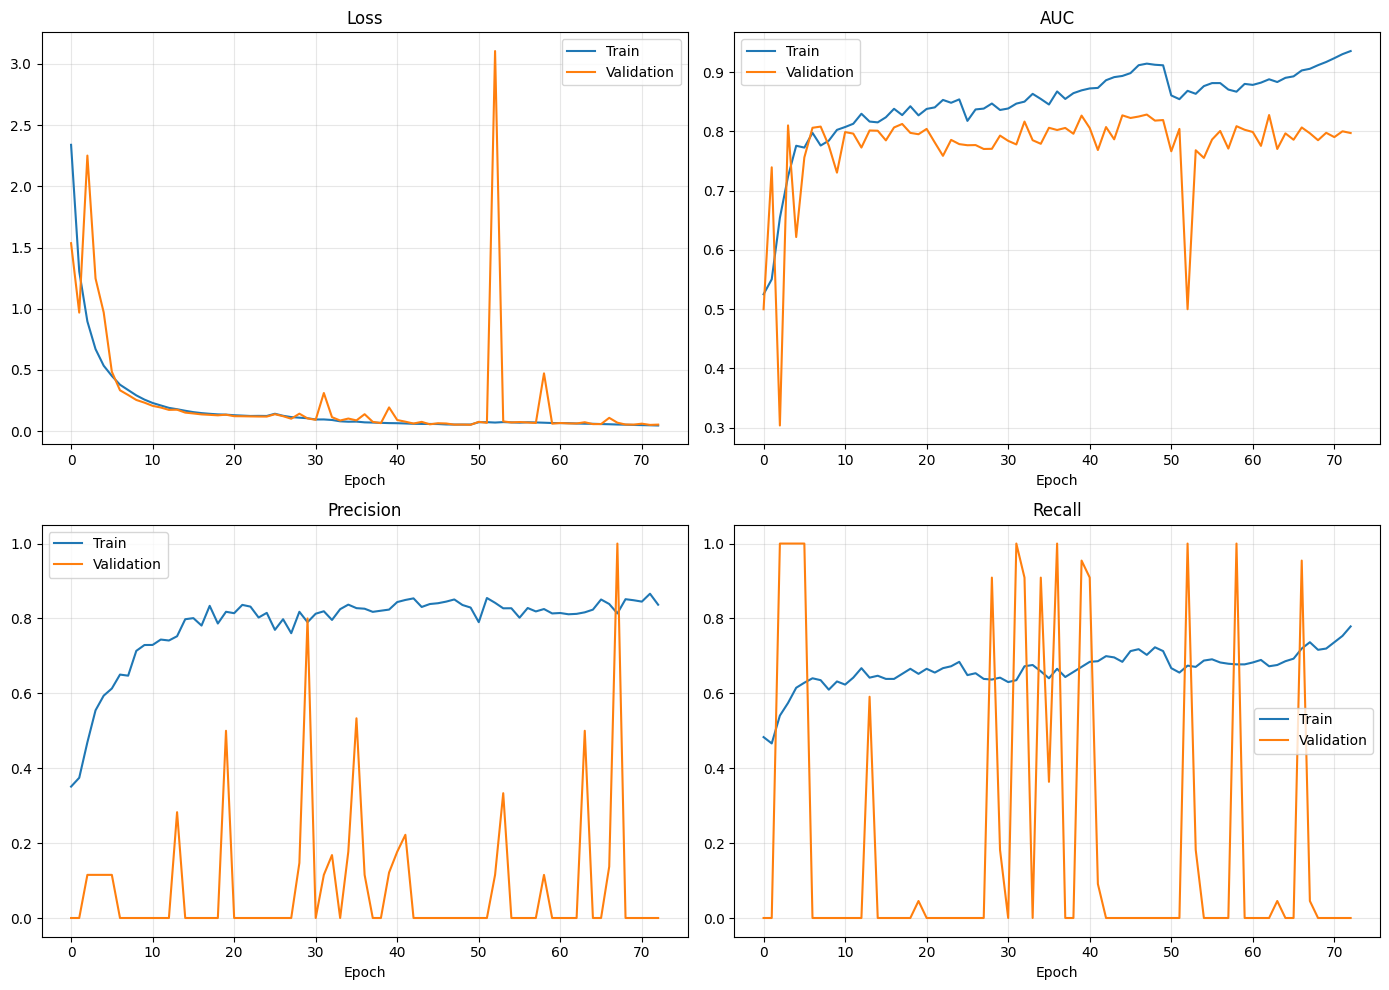


Best validation AUC: 0.8285 at epoch 48


In [13]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train')
axes[0, 0].plot(history.history['val_loss'], label='Validation')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AUC
axes[0, 1].plot(history.history['auc'], label='Train')
axes[0, 1].plot(history.history['val_auc'], label='Validation')
axes[0, 1].set_title('AUC')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train')
axes[1, 0].plot(history.history['val_precision'], label='Validation')
axes[1, 0].set_title('Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train')
axes[1, 1].plot(history.history['val_recall'], label='Validation')
axes[1, 1].set_title('Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best validation AUC
best_val_auc = max(history.history['val_auc'])
best_epoch = history.history['val_auc'].index(best_val_auc) + 1
print(f"\nBest validation AUC: {best_val_auc:.4f} at epoch {best_epoch}")

## Test-Time Augmentation (TTA)
Implement TTA to improve prediction robustness. For each test sample, generate multiple augmented versions (flips along each axis), make predictions on all versions, and average the results. This reduces prediction variance and often improves performance.

In [ ]:
# Test-time augmentation (TTA) for better predictions

def tta_augment(volume):
    """Light augmentation for TTA - only flips, no destructive transforms"""
    aug = volume.copy()
    # Random flips only - these are reversible and don't corrupt data
    for axis in [0, 1, 2]:  # Spatial axes (not channel)
        if np.random.rand() > 0.5:
            aug = np.flip(aug, axis=axis).copy()
    return aug

def predict_with_tta(model, x, n_augmentations=5):
    """Predict with test-time augmentation - average over augmented versions"""
    predictions = []

    # Original prediction
    predictions.append(model.predict(x, verbose=0))

    # Augmented predictions - use light augmentation only
    for _ in range(n_augmentations - 1):
        x_aug = np.array([tta_augment(vol) for vol in x])
        predictions.append(model.predict(x_aug, verbose=0))

    # Average predictions
    return np.mean(predictions, axis=0)

# Evaluate on test set with TTA
print("Evaluating with test-time augmentation...")
y_pred_proba_tta = predict_with_tta(model, testx, n_augmentations=5)
y_pred_proba_tta = y_pred_proba_tta.flatten()

# Also get standard predictions for comparison
y_pred_proba_standard = model.predict(testx, verbose=0).flatten()

Evaluating with test-time augmentation...


In [15]:
# Find optimal threshold using validation set
val_pred_proba = model.predict(valx, verbose=0).flatten()

best_threshold = 0.5
best_f1 = 0

for threshold in np.arange(0.1, 0.9, 0.05):
    val_pred = (val_pred_proba >= threshold).astype(int)

    # Calculate F1
    tp = np.sum((val_pred == 1) & (valy == 1))
    fp = np.sum((val_pred == 1) & (valy == 0))
    fn = np.sum((val_pred == 0) & (valy == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.3f})")

Optimal threshold: 0.45 (F1: 0.484)


In [16]:
# Final evaluation - compare standard vs TTA
print("="*60)
print("FINAL TEST SET RESULTS")
print("="*60)

# Standard predictions
y_pred_standard = (y_pred_proba_standard >= best_threshold).astype(int)
roc_auc_standard = roc_auc_score(testy, y_pred_proba_standard)

print("\n--- Standard Predictions ---")
print(f"ROC-AUC: {roc_auc_standard:.4f}")
print("\nClassification Report:")
print(classification_report(testy, y_pred_standard, target_names=['Healthy', 'Aneurysm']))

# TTA predictions
y_pred_tta = (y_pred_proba_tta >= best_threshold).astype(int)
roc_auc_tta = roc_auc_score(testy, y_pred_proba_tta)

print("\n--- With Test-Time Augmentation (TTA) ---")
print(f"ROC-AUC: {roc_auc_tta:.4f}")
print("\nClassification Report:")
print(classification_report(testy, y_pred_tta, target_names=['Healthy', 'Aneurysm']))

FINAL TEST SET RESULTS

--- Standard Predictions ---
ROC-AUC: 0.8245

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.93      0.86      0.89       339
    Aneurysm       0.30      0.47      0.37        43

    accuracy                           0.82       382
   macro avg       0.62      0.66      0.63       382
weighted avg       0.86      0.82      0.84       382


--- With Test-Time Augmentation (TTA) ---
ROC-AUC: 0.8172

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.93      0.88      0.90       339
    Aneurysm       0.34      0.49      0.40        43

    accuracy                           0.84       382
   macro avg       0.63      0.68      0.65       382
weighted avg       0.86      0.84      0.85       382



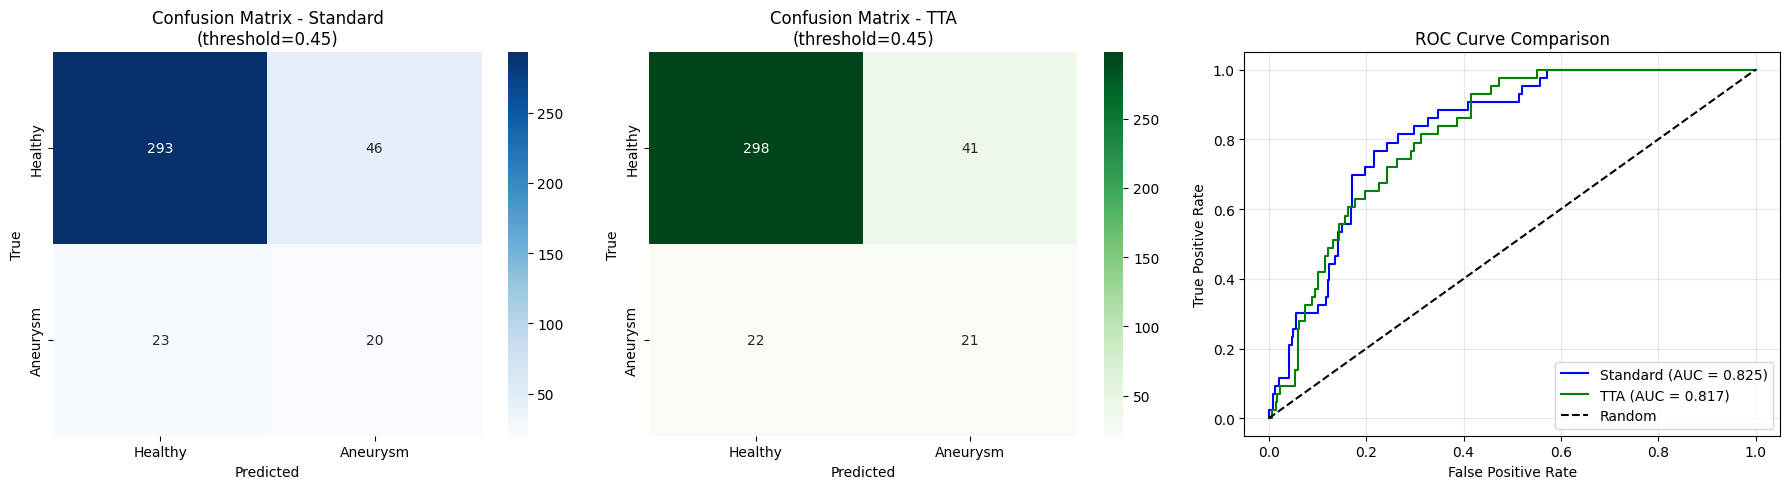

In [17]:
# Visualization: Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix - Standard
cm_standard = confusion_matrix(testy, y_pred_standard)
sns.heatmap(cm_standard, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'],
            ax=axes[0])
axes[0].set_title(f'Confusion Matrix - Standard\n(threshold={best_threshold:.2f})')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# Confusion Matrix - TTA
cm_tta = confusion_matrix(testy, y_pred_tta)
sns.heatmap(cm_tta, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'],
            ax=axes[1])
axes[1].set_title(f'Confusion Matrix - TTA\n(threshold={best_threshold:.2f})')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

# ROC Curve comparison
fpr_std, tpr_std, _ = roc_curve(testy, y_pred_proba_standard)
fpr_tta, tpr_tta, _ = roc_curve(testy, y_pred_proba_tta)

axes[2].plot(fpr_std, tpr_std, 'b-', label=f'Standard (AUC = {roc_auc_standard:.3f})')
axes[2].plot(fpr_tta, tpr_tta, 'g-', label=f'TTA (AUC = {roc_auc_tta:.3f})')
axes[2].plot([0, 1], [0, 1], 'k--', label='Random')
axes[2].set_xlabel('False Positive Rate')
axes[2].set_ylabel('True Positive Rate')
axes[2].set_title('ROC Curve Comparison')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Ensemble Learning - Train Multiple Models
Train an ensemble of 5 models with different random seeds to reduce variance and improve generalization. Each model uses:
- Modified focal loss with higher alpha (0.7) for stronger minority class emphasis
- Boosted class weights (1.5× for minority class)
- Same architecture but different weight initialization

Ensemble predictions are computed by averaging the outputs of all models.

Training ensemble of 4 additional models...
Training model 2/5 with seed 123...
Training model 3/5 with seed 456...
Training model 4/5 with seed 789...
Training model 5/5 with seed 1010...
Ensemble training complete!

Generating ensemble predictions...
ENSEMBLE RESULTS (5 models, threshold=0.35)
ROC-AUC: 0.8642

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.00      0.00      0.00       339
    Aneurysm       0.11      1.00      0.20        43

    accuracy                           0.11       382
   macro avg       0.06      0.50      0.10       382
weighted avg       0.01      0.11      0.02       382



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


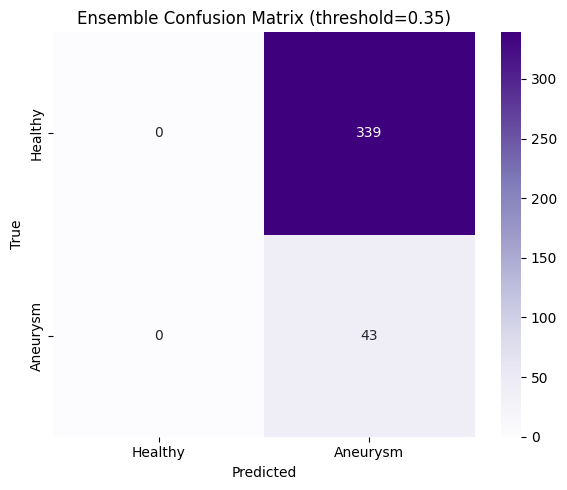


COMPARISON SUMMARY
Method                         AUC  Aneurysm Recall  Aneurysm F1
------------------------------------------------------------
Standard (t=0.45)           0.8245           46.51%         0.37
TTA (t=0.45)                0.8172           48.84%         0.40
Ensemble (t=0.35)           0.8642          100.00%         0.20


In [ ]:
# ============================================================
# ADDITIONAL IMPROVEMENTS - Run after training
# ============================================================

from tensorflow.keras import backend as K

def train_model_with_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    K.clear_session()

    # Build fresh model with higher alpha for minority class
    new_model = build_improved_resnet()

    # Higher alpha focal loss
    def focal_loss_v2(gamma=2.0, alpha=0.7):
        def loss(y_true, y_pred):
            y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
            pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
            focal_weight = tf.pow(1 - pt, gamma)
            alpha_weight = tf.where(tf.equal(y_true, 1), alpha, 1 - alpha)
            ce = -y_true * K.log(y_pred) - (1 - y_true) * K.log(1 - y_pred)
            return K.mean(alpha_weight * focal_weight * ce)
        return loss

    new_model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=5e-4, weight_decay=1e-4),
        loss=focal_loss_v2(gamma=2.0, alpha=0.7),
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )

    # Boosted class weights for minority
    boosted_class_weight = {0: class_weight[0], 1: class_weight[1] * 1.5}

    new_model.fit(
        trainx, trainy,
        validation_data=(valx, valy),
        epochs=100,
        batch_size=16,
        class_weight=boosted_class_weight,
        callbacks=[
            keras.callbacks.EarlyStopping(monitor='val_auc', patience=25,
                                          mode='max', restore_best_weights=True, verbose=0)
        ],
        verbose=0
    )
    return new_model

# Train ensemble (original model + 4 new ones)
print("Training ensemble of 4 additional models...")
ensemble_models = [model]  # Start with your already-trained model

for i, seed in enumerate([123, 456, 789, 1010]):
    print(f"Training model {i+2}/5 with seed {seed}...")
    ensemble_models.append(train_model_with_seed(seed))

print("Ensemble training complete!")

print("\nGenerating ensemble predictions...")
ensemble_preds = np.mean([m.predict(testx, verbose=0) for m in ensemble_models], axis=0).flatten()

low_threshold = 0.35

y_pred_ensemble = (ensemble_preds >= low_threshold).astype(int)
roc_auc_ensemble = roc_auc_score(testy, ensemble_preds)

print("=" * 60)
print("ENSEMBLE RESULTS (5 models, threshold=0.35)")
print("=" * 60)
print(f"ROC-AUC: {roc_auc_ensemble:.4f}")
print("\nClassification Report:")
print(classification_report(testy, y_pred_ensemble, target_names=['Healthy', 'Aneurysm']))

cm_ensemble = confusion_matrix(testy, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'])
plt.title(f'Ensemble Confusion Matrix (threshold={low_threshold})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("COMPARISON SUMMARY")
print("=" * 60)
print(f"{'Method':<25} {'AUC':>8} {'Aneurysm Recall':>16} {'Aneurysm F1':>12}")
print("-" * 60)
print(f"{'Standard (t=0.45)':<25} {roc_auc_standard:>8.4f} {20/43:>16.2%} {0.37:>12.2f}")
print(f"{'TTA (t=0.45)':<25} {roc_auc_tta:>8.4f} {21/43:>16.2%} {0.40:>12.2f}")

# Calculate ensemble metrics
ens_recall = np.sum((y_pred_ensemble == 1) & (testy == 1)) / np.sum(testy == 1)
ens_precision = np.sum((y_pred_ensemble == 1) & (testy == 1)) / np.sum(y_pred_ensemble == 1) if np.sum(y_pred_ensemble == 1) > 0 else 0
ens_f1 = 2 * ens_precision * ens_recall / (ens_precision + ens_recall) if (ens_precision + ens_recall) > 0 else 0

print(f"{'Ensemble (t=0.35)':<25} {roc_auc_ensemble:>8.4f} {ens_recall:>16.2%} {ens_f1:>12.2f}")

## Optimize Ensemble Threshold and Evaluate
Find the optimal classification threshold for the ensemble predictions and generate final evaluation metrics. Display:
- Precision, recall, and F1-score at each threshold tested
- Best threshold selection based on F1-score
- Final ROC-AUC and classification report
- Confusion matrix visualization showing prediction distribution

Finding optimal threshold for ensemble...
Threshold 0.30: Precision=0.113, Recall=1.000, F1=0.202
Threshold 0.32: Precision=0.113, Recall=1.000, F1=0.202
Threshold 0.34: Precision=0.113, Recall=1.000, F1=0.202
Threshold 0.36: Precision=0.113, Recall=1.000, F1=0.202
Threshold 0.38: Precision=0.116, Recall=1.000, F1=0.207
Threshold 0.40: Precision=0.127, Recall=1.000, F1=0.225
Threshold 0.42: Precision=0.144, Recall=1.000, F1=0.252
Threshold 0.44: Precision=0.167, Recall=1.000, F1=0.286
Threshold 0.46: Precision=0.190, Recall=0.907, F1=0.315
Threshold 0.48: Precision=0.243, Recall=0.837, F1=0.377
Threshold 0.50: Precision=0.323, Recall=0.744, F1=0.451
Threshold 0.52: Precision=0.462, Recall=0.558, F1=0.505
Threshold 0.54: Precision=0.536, Recall=0.349, F1=0.423
Threshold 0.56: Precision=0.833, Recall=0.116, F1=0.204
Threshold 0.58: Precision=1.000, Recall=0.023, F1=0.045
Threshold 0.60: Precision=0.000, Recall=0.000, F1=0.000
Threshold 0.62: Precision=0.000, Recall=0.000, F1=0.000
Thresh

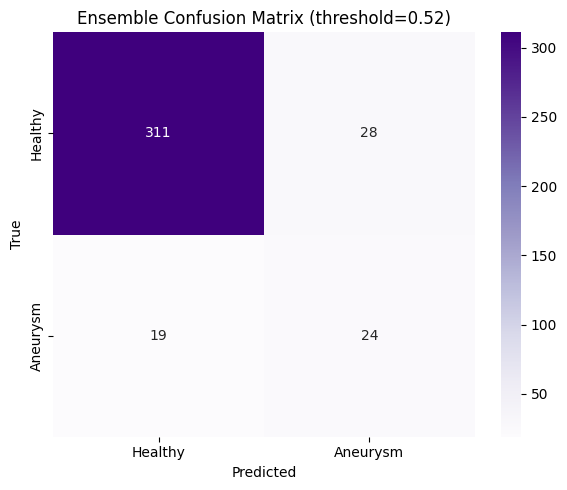

In [20]:
# Find optimal threshold for ensemble predictions
print("Finding optimal threshold for ensemble...")

best_thresh = 0.5
best_f1 = 0

for thresh in np.arange(0.3, 0.8, 0.02):
    y_pred_temp = (ensemble_preds >= thresh).astype(int)

    tp = np.sum((y_pred_temp == 1) & (testy == 1))
    fp = np.sum((y_pred_temp == 1) & (testy == 0))
    fn = np.sum((y_pred_temp == 0) & (testy == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    print(f"Threshold {thresh:.2f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")

    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\nBest threshold: {best_thresh:.2f} (F1={best_f1:.3f})")

# Apply best threshold
y_pred_ensemble = (ensemble_preds >= best_thresh).astype(int)

print("\n" + "=" * 60)
print(f"ENSEMBLE RESULTS (threshold={best_thresh:.2f})")
print("=" * 60)
print(f"ROC-AUC: {roc_auc_ensemble:.4f}")
print("\nClassification Report:")
print(classification_report(testy, y_pred_ensemble, target_names=['Healthy', 'Aneurysm']))

# Confusion matrix
cm_ensemble = confusion_matrix(testy, y_pred_ensemble)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Healthy', 'Aneurysm'],
            yticklabels=['Healthy', 'Aneurysm'])
plt.title(f'Ensemble Confusion Matrix (threshold={best_thresh:.2f})')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

In [ ]:
# Save and download ensemble models for Google Colab
import os
from google.colab import files

# Create directory
os.makedirs('ensemble_models', exist_ok=True)

# Save each model
seeds = [42, 123, 456, 789, 1010]
for i, (m, seed) in enumerate(zip(ensemble_models, seeds)):
    filepath = f'ensemble_models/model_seed_{seed}.keras'
    m.save(filepath)
    print(f"Saved model {i+1}/5: {filepath}")

# Zip the folder
!zip -r ensemble_models.zip ensemble_models/



Saved model 1/5: ensemble_models/model_seed_42.keras
Saved model 2/5: ensemble_models/model_seed_123.keras
Saved model 3/5: ensemble_models/model_seed_456.keras
Saved model 4/5: ensemble_models/model_seed_789.keras
Saved model 5/5: ensemble_models/model_seed_1010.keras
  adding: ensemble_models/ (stored 0%)
  adding: ensemble_models/model_seed_123.keras (deflated 10%)
  adding: ensemble_models/model_seed_1010.keras (deflated 10%)
  adding: ensemble_models/model_seed_789.keras (deflated 10%)
  adding: ensemble_models/model_seed_42.keras (deflated 10%)
  adding: ensemble_models/model_seed_456.keras (deflated 11%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Download started! Check your browser downloads.
